In [1]:
import pandas as pd
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

import sys 
sys.path.append('../../')
import laggedfeature
import propperties

In [2]:
df = pd.read_csv('../../../Data/BTC-USD.csv', usecols=['Date', 'Close'])
df['Date'] = pd.to_datetime(df['Date'])
df['MonthYear'] = df['Date'].dt.year.astype(str) +'-'+df['Date'].dt.month.astype(str)
df['MonthYear'] = df['MonthYear'].drop_duplicates()
df.dropna()
df.reset_index(drop=True)
df

,Date,Close,MonthYear
0,2014-09-17,457.334015,2014-9
1,2014-09-18,424.440002,NaN
2,2014-09-19,394.795990,NaN
3,2014-09-20,408.903992,NaN
4,2014-09-21,398.821014,NaN
...,...,...,...
3188,2023-06-10,25851.240230,NaN
3189,2023-06-11,25940.167970,NaN
3190,2023-06-12,25902.500000,NaN
3191,2023-06-13,25918.728520,NaN


In [3]:
# Create lagged feature
num_lags = 7
df['Lag'] = laggedfeature.set(num_lags, df['Close'])

In [4]:
# Train test val split in 6-2-2 set
test_size = int(len(df)*0.20)
val_size = int(len(df)*0.20)
train_size = int(len(df)-test_size-val_size)

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [5]:
X_train = np.array(train_data['Lag']).reshape(-1,1)
X_test = np.array(test_data['Lag']).reshape(-1,1) 
X_val = np.array(val_data['Lag']).reshape(-1,1) 
y_train = train_data['Close']
y_test = test_data['Close']
y_val = val_data['Close']

In [6]:
model = KNeighborsRegressor(n_neighbors=propperties.N_NEIGHBORS)
model.fit(X_train, y_train)
print("Model Accuracy: %.3f" % model.score(X_test, y_test))

Model Accuracy: -0.100


In [7]:
# Predictions
y_test_pred = model.predict(X_test) 
y_val_pred = model.predict(X_val)   

In [8]:
# RMSE
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("The root mean squared error (RMSE) on test set: {:.3f}".format(rmse))

The root mean squared error (RMSE) on test set: 18720.236


In [9]:
# MAPE
mape = mean_absolute_percentage_error(test_data['Close'], y_test_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))

The mean absolute percentage error (MAPE) on test set: 0.287


In [10]:
# EVS 
evs = explained_variance_score(test_data['Close'], y_test_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))

The explained variance score (EVS) on test set: 0.321


In [11]:
# Predicting next 30 days' prices 
last_index=df.index[-1]

X_30 = laggedfeature.set_30(num_lags, df['Close'])
X_30.index = pd.RangeIndex(start=last_index+1, stop=last_index+31)
y_30_pred = model.predict(X_30)

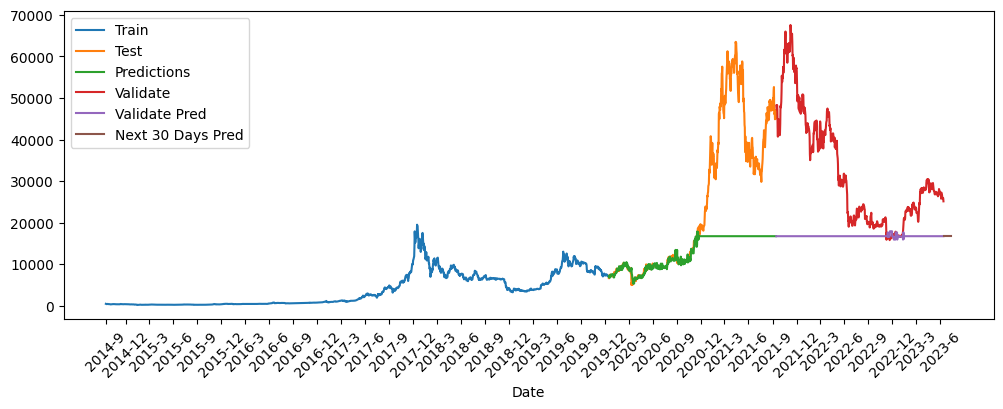

In [12]:
plt.subplots(figsize=(12, 4))
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_test_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_val_pred)
plt.plot(X_30.index, y_30_pred)
plt.legend(['Train', 'Test', 'Predictions', 'Validate',
           'Validate Pred', 'Next 30 Days Pred'])

temp = df.dropna(subset=['MonthYear'])
temp = temp['MonthYear'].loc[::3]
plt.xticks(temp.index, temp, rotation=45)

plt.set_cmap('summer')
plt.xlabel('Date')
plt.show()


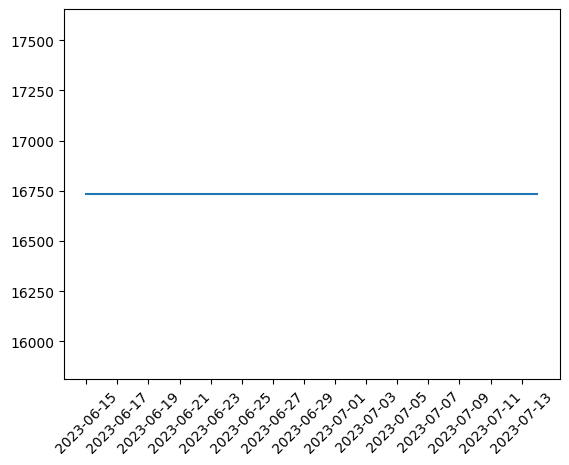

In [13]:
import datetime

last_day = df['Date'].iloc[-1]
next_days = np.array([])

for i in range(0, 30):
    last_day = last_day+datetime.timedelta(days=1)
    next_days = np.append(next_days, last_day)

plt.plot(next_days, y_30_pred)
plt.xticks(next_days[::2], rotation=45)
plt.show()